# Prompt 4: How would a census tract ranking based on the cumulative distribution of nature-based solutions compare to CalEnviroScreen 4.0?

### What is CalEnviroScreen 4.0?

https://oehha.ca.gov/calenviroscreen/scoring-model

CalEnviroScreen uses environmental, health, and socioeconomic information to produce scores for every census tract in the state. The scores are mapped so that different communities can be compared. An area with a high score is one that experiences a much higher pollution burden than areas with low scores.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import json
import requests
import geopandas as gpd

In [2]:
pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 KB 16.7 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Importing CalEnviroScreen 4.0 Data

Removed missing/NAN values, selected only tracts in the Bay Area, and adjusted some column names.

In [3]:
calenviro = pd.read_excel(io = "CalEnviroScreen_4.0Excel_ADA_D1_2021.xlsx", sheet_name = 'DRAFTCES4.0_results')
calenviro[" CES 4.0 Percentile"] = calenviro["DRAFT CES 4.0 Percentile"]
bay_area_counties = ['Marin ', 'San Mateo', 'Napa ', 'Contra Costa', 'Santa Clara', 'Alameda ', 'Sonoma ', 'San Francisco', 'Solano ']
calenviro = calenviro[calenviro["California County"].isin(bay_area_counties)]
calenviro = calenviro.dropna()
calenviro

,Census Tract,Total Population,California County,ZIP,Nearby City \n(to help approximate location only),Longitude,Latitude,DRAFT CES 4.0 Score,DRAFT CES 4.0 Percentile,DRAFT CES 4.0\nPercentile Range,...,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl,CES 4.0 Percentile
162,6001407300,2440,Alameda,94601,Oakland,-122.210924,37.762179,64.580115,97.957125,95-100% (highest scores),...,56.9,86.608040,12.8,91.609744,31.5,91.917531,83.997258,8.708981,95.825977,97.957125
200,6001408800,7054,Alameda,94621,Oakland,-122.196942,37.758804,63.194836,97.477932,95-100% (highest scores),...,66.6,94.396985,10.9,85.810027,28.2,85.618518,90.784474,9.412691,99.205549,97.477932
217,6001409000,3904,Alameda,94621,Oakland,-122.221368,37.720011,62.666135,97.263556,95-100% (highest scores),...,41.6,68.165829,8.0,69.338832,23.9,74.500379,82.018449,8.503815,94.312736,97.263556
248,6095250701,3595,Solano,94590,Vallejo,-122.244902,38.090042,61.811844,96.872636,95-100% (highest scores),...,42.7,69.673367,10.9,85.810027,25.7,79.850746,82.954826,8.600900,95.081967,96.872636
338,6013365002,5739,Contra Costa,94801,Richmond,-122.384395,37.959466,59.572823,95.737705,95-100% (highest scores),...,47.8,76.570352,5.7,44.889805,28.6,86.529218,83.136469,8.619733,95.182850,95.737705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7925,6041127000,4678,Marin,94941,Mill Valley,-122.558505,37.910441,1.550410,0.063052,1-5% (lowest scores),...,9.2,7.625628,2.0,4.266014,10.7,15.279535,5.958253,0.617762,0.151324,0.063052
7926,6013352101,3338,Contra Costa,94556,Moraga,-122.095336,37.845069,1.530183,0.050441,1-5% (lowest scores),...,7.5,4.547739,3.5,17.347596,8.6,7.728308,6.162890,0.638979,0.176545,0.050441
7927,6013353002,4353,Contra Costa,94563,Orinda,-122.168419,37.879503,1.495871,0.037831,1-5% (lowest scores),...,3.8,0.540201,2.5,7.616961,9.8,11.763218,5.001257,0.518539,0.088272,0.037831
7928,6013351200,6191,Contra Costa,94549,Lafayette,-122.105108,37.868286,1.268794,0.025221,1-5% (lowest scores),...,4.2,0.829146,2.2,5.529063,8.0,6.046041,4.305407,0.446392,0.037831,0.025221


In [5]:
our_scores = pd.read_csv("/work/bay_area_tracts_cleaned.csv") #cleaned dataset from the api
our_scores

,census_tract,carbon_urbanforest_value,floodplain100_value,floodplain500_value,floodplain500_natural_value,waterqualityindex_value,drinkingwater_value,reservoir_value,hirechargevulnerable_value,waterbasin_value,...,watersites_existing_value,protected_fee_value,linkage_diffuse_value,linkage_intensified_value,linkage_channelized_value,linkage_large_value,linkage_reglink_value,displacement_typos_value,communityconcern_value,disadvcommunity_value
0,6001451704,11922,0,0,0,lower than average,0,False,426,False,...,0,21,0,0,0,0,0,0,0,0
1,6001428301,12630,151,231,27,lower than average,0,False,0,False,...,0,26,0,0,0,0,0,3,7,29
2,6001407000,2085,0,0,0,lower than average,0,False,0,False,...,0,2,0,0,0,0,0,213,212,0
3,6001422400,2643,0,0,0,lower than average,0,False,0,False,...,0,1,0,0,0,0,0,0,0,0
4,6001423200,2686,0,0,0,lower than average,0,False,0,False,...,0,0,0,0,0,0,0,0,112,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759,6075021500,4127,0,0,0,lower than average,0,False,0,False,...,0,3,0,0,0,0,0,0,0,0
1760,6075020701,1932,0,0,0,lower than average,0,False,0,False,...,0,2,0,0,0,0,0,51,0,0
1761,6075026404,718,0,0,0,lower than average,0,False,0,False,...,0,1,0,0,0,0,0,49,49,0
1762,6075030400,11828,0,0,0,lower than average,0,False,0,False,...,0,5,0,0,0,0,0,0,0,0


From this distribution, and others, we decided to standardize our data to create a score for NBS

In [7]:
# selecting NBS columns (based on Carrie's priority variables)
nbs_cols = ["wetlands_value", "vernalpools_value", "naturalriver_value", "naturalbaylands_value", "hirechargevulnerable_value", "floodplain500_natural_value", "carbon_urbanforest_value", "drinkingwater_value"]
our_scores_nbs = our_scores[["wetlands_value", "vernalpools_value", "naturalriver_value", "naturalbaylands_value", "hirechargevulnerable_value", "floodplain500_natural_value", "carbon_urbanforest_value", "drinkingwater_value"]]
our_scores_nbs

,wetlands_value,vernalpools_value,naturalriver_value,naturalbaylands_value,hirechargevulnerable_value,floodplain500_natural_value,carbon_urbanforest_value,drinkingwater_value
0,0,0,0,0,426,0,11922,0
1,46,0,14,1,0,27,12630,0
2,0,0,0,0,0,0,2085,0
3,0,0,0,0,0,0,2643,0
4,0,0,0,0,0,0,2686,0
...,...,...,...,...,...,...,...,...
1759,0,0,0,0,0,0,4127,0
1760,0,0,0,0,0,0,1932,0
1761,0,0,0,0,0,0,718,0
1762,0,0,0,0,0,0,11828,0


### Looking Into the dataset more to determine how to calculate the NBS score

In [8]:
#for i, nbs in enumerate(nbs_cols):
    #plt.figure(i)
    #plt.title(nbs)
    #our_scores[nbs].plot()



We decided to remove columns with boolean values because they contained mainly false values and made standardizing more difficult

In [9]:
#standardizing the NBS values 
#for nbs in nbs_cols:
    #our_scores[nbs] = stats.zscore(our_scores[nbs])

totals = our_scores[nbs_cols].sum(axis=1)
totals

0       12348
1       12718
2        2085
3        2643
4        2686
        ...  
1759     4127
1760     1932
1761      718
1762    11828
1763        0
Length: 1764, dtype: int64

In [10]:
d = {"census_tract":our_scores['census_tract'], "Total":totals}
tract_scores = pd.DataFrame(data=d)
tract_scores

,census_tract,Total
0,6001451704,12348
1,6001428301,12718
2,6001407000,2085
3,6001422400,2643
4,6001423200,2686
...,...,...
1759,6075021500,4127
1760,6075020701,1932
1761,6075026404,718
1762,6075030400,11828


<AxesSubplot: >

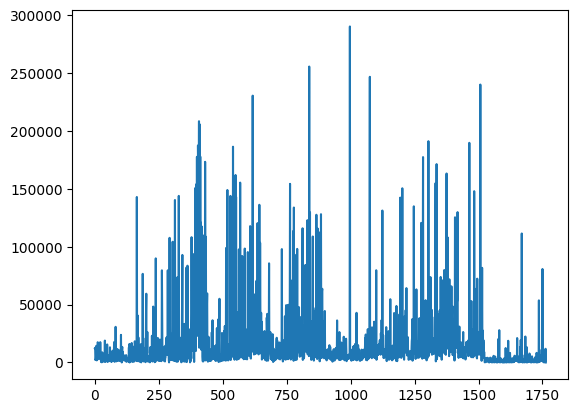

In [11]:
tract_scores["Total"].plot()

In [12]:
#turning the standardized scores into percentiles based on z-score
#p_values = stats.norm.sf(abs(tract_scores["z-score"])) #twosided 

tract_scores["NBS Score"] = tract_scores.apply(lambda x: stats.percentileofscore(tract_scores["Total"], x["Total"]), axis =1)
tract_scores["NBS Score"] = 100 - tract_scores["NBS Score"]
tract_scores

#tract_scores.sort_values("NBS Score", ascending = False)

,census_tract,Total,NBS Score
0,6001451704,12348,34.750567
1,6001428301,12718,33.588435
2,6001407000,2085,84.523810
3,6001422400,2643,79.138322
4,6001423200,2686,78.798186
...,...,...,...
1759,6075021500,4127,67.517007
1760,6075020701,1932,85.544218
1761,6075026404,718,95.068027
1762,6075030400,11828,35.572562


In [13]:
# Checking to see if the percentiles I use make sense
totals = sum(tract_scores["Total"])
sanity_check = tract_scores[tract_scores["census_tract"] == 6001451704]
100 - stats.percentileofscore(tract_scores["Total"], sanity_check["Total"]) == sanity_check["NBS Score"]

0    True
Name: NBS Score, dtype: bool

In [14]:
calenviro["CES Score"] = calenviro.apply(lambda x: stats.percentileofscore(calenviro[" CES 4.0 Percentile"], x[" CES 4.0 Percentile"]), axis = 1)
#calenviro.sort_values("CES Score", ascending = False)[["Census Tract"," CES Score", "California County"]]
calenviro["CES Score"]

162     100.000000
200      99.933200
217      99.866399
248      99.799599
338      99.732799
           ...    
7925      0.334001
7926      0.267201
7927      0.200401
7928      0.133601
7929      0.066800
Name: CES Score, Length: 1497, dtype: float64

# Looking at the difference between Cal Enviro Screen 4.0 and NBS for all census tracts  

In [15]:
all_merged = calenviro.merge(tract_scores, left_on = 'Census Tract', right_on = 'census_tract')

In [16]:
all_merged


,Census Tract,Total Population,California County,ZIP,Nearby City \n(to help approximate location only),Longitude,Latitude,DRAFT CES 4.0 Score,DRAFT CES 4.0 Percentile,DRAFT CES 4.0\nPercentile Range,...,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl,CES 4.0 Percentile,CES Score,census_tract,Total,NBS Score
0,6001407300,2440,Alameda,94601,Oakland,-122.210924,37.762179,64.580115,97.957125,95-100% (highest scores),...,31.5,91.917531,83.997258,8.708981,95.825977,97.957125,100.000000,6001407300,418,96.371882
1,6001408800,7054,Alameda,94621,Oakland,-122.196942,37.758804,63.194836,97.477932,95-100% (highest scores),...,28.2,85.618518,90.784474,9.412691,99.205549,97.477932,99.933200,6001408800,740,94.841270
2,6001409000,3904,Alameda,94621,Oakland,-122.221368,37.720011,62.666135,97.263556,95-100% (highest scores),...,23.9,74.500379,82.018449,8.503815,94.312736,97.263556,99.866399,6001409000,4725,63.151927
3,6095250701,3595,Solano,94590,Vallejo,-122.244902,38.090042,61.811844,96.872636,95-100% (highest scores),...,25.7,79.850746,82.954826,8.600900,95.081967,96.872636,99.799599,6095250701,6045,55.895692
4,6013365002,5739,Contra Costa,94801,Richmond,-122.384395,37.959466,59.572823,95.737705,95-100% (highest scores),...,28.6,86.529218,83.136469,8.619733,95.182850,95.737705,99.732799,6013365002,9092,43.990930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325,6041127000,4678,Marin,94941,Mill Valley,-122.558505,37.910441,1.550410,0.063052,1-5% (lowest scores),...,10.7,15.279535,5.958253,0.617762,0.151324,0.063052,0.334001,6041127000,150627,1.417234
1326,6013352101,3338,Contra Costa,94556,Moraga,-122.095336,37.845069,1.530183,0.050441,1-5% (lowest scores),...,8.6,7.728308,6.162890,0.638979,0.176545,0.050441,0.267201,6013352101,39901,11.734694
1327,6013353002,4353,Contra Costa,94563,Orinda,-122.168419,37.879503,1.495871,0.037831,1-5% (lowest scores),...,9.8,11.763218,5.001257,0.518539,0.088272,0.037831,0.200401,6013353002,113628,3.174603
1328,6013351200,6191,Contra Costa,94549,Lafayette,-122.105108,37.868286,1.268794,0.025221,1-5% (lowest scores),...,8.0,6.046041,4.305407,0.446392,0.037831,0.025221,0.133601,6013351200,108851,3.401361


In [17]:
all_merged

,Census Tract,Total Population,California County,ZIP,Nearby City \n(to help approximate location only),Longitude,Latitude,DRAFT CES 4.0 Score,DRAFT CES 4.0 Percentile,DRAFT CES 4.0\nPercentile Range,...,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl,CES 4.0 Percentile,CES Score,census_tract,Total,NBS Score
0,6001407300,2440,Alameda,94601,Oakland,-122.210924,37.762179,64.580115,97.957125,95-100% (highest scores),...,31.5,91.917531,83.997258,8.708981,95.825977,97.957125,100.000000,6001407300,418,96.371882
1,6001408800,7054,Alameda,94621,Oakland,-122.196942,37.758804,63.194836,97.477932,95-100% (highest scores),...,28.2,85.618518,90.784474,9.412691,99.205549,97.477932,99.933200,6001408800,740,94.841270
2,6001409000,3904,Alameda,94621,Oakland,-122.221368,37.720011,62.666135,97.263556,95-100% (highest scores),...,23.9,74.500379,82.018449,8.503815,94.312736,97.263556,99.866399,6001409000,4725,63.151927
3,6095250701,3595,Solano,94590,Vallejo,-122.244902,38.090042,61.811844,96.872636,95-100% (highest scores),...,25.7,79.850746,82.954826,8.600900,95.081967,96.872636,99.799599,6095250701,6045,55.895692
4,6013365002,5739,Contra Costa,94801,Richmond,-122.384395,37.959466,59.572823,95.737705,95-100% (highest scores),...,28.6,86.529218,83.136469,8.619733,95.182850,95.737705,99.732799,6013365002,9092,43.990930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325,6041127000,4678,Marin,94941,Mill Valley,-122.558505,37.910441,1.550410,0.063052,1-5% (lowest scores),...,10.7,15.279535,5.958253,0.617762,0.151324,0.063052,0.334001,6041127000,150627,1.417234
1326,6013352101,3338,Contra Costa,94556,Moraga,-122.095336,37.845069,1.530183,0.050441,1-5% (lowest scores),...,8.6,7.728308,6.162890,0.638979,0.176545,0.050441,0.267201,6013352101,39901,11.734694
1327,6013353002,4353,Contra Costa,94563,Orinda,-122.168419,37.879503,1.495871,0.037831,1-5% (lowest scores),...,9.8,11.763218,5.001257,0.518539,0.088272,0.037831,0.200401,6013353002,113628,3.174603
1328,6013351200,6191,Contra Costa,94549,Lafayette,-122.105108,37.868286,1.268794,0.025221,1-5% (lowest scores),...,8.0,6.046041,4.305407,0.446392,0.037831,0.025221,0.133601,6013351200,108851,3.401361


In [18]:
all_merged["Census Tract"] = all_merged["Census Tract"].astype('category')
all_merged["Census Tract"]

0       6001407300
1       6001408800
2       6001409000
3       6095250701
4       6013365002
           ...    
1325    6041127000
1326    6013352101
1327    6013353002
1328    6013351200
1329    6041126100
Name: Census Tract, Length: 1330, dtype: category
Categories (1330, int64): [6001400200, 6001400300, 6001400400, 6001400500, ..., 6097154100, 6097154201, 6097154202, 6097154304]

Text(0.5, 1.0, 'CES 4.0 Percentile for all of the Census Tracts')

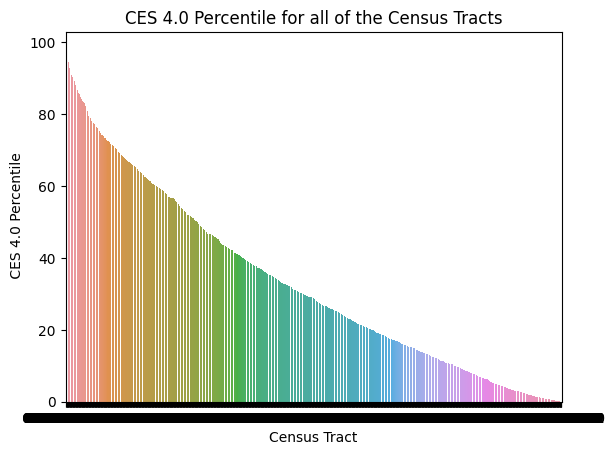

In [19]:
sns.barplot(data=all_merged, x='Census Tract', y=' CES 4.0 Percentile', order = all_merged["Census Tract"])
plt.title("CES 4.0 Percentile for all of the Census Tracts")

Text(0.5, 1.0, 'NBS scores for all of the Census Tracts')

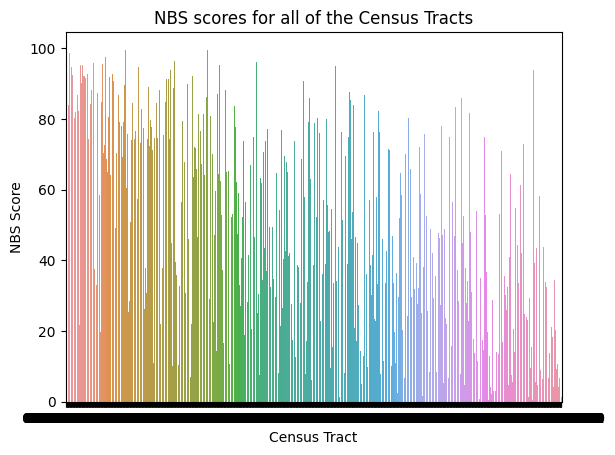

In [20]:
sns.barplot(data=all_merged, x='Census Tract', y='NBS Score', order = all_merged['Census Tract'])
plt.title("NBS scores for all of the Census Tracts")

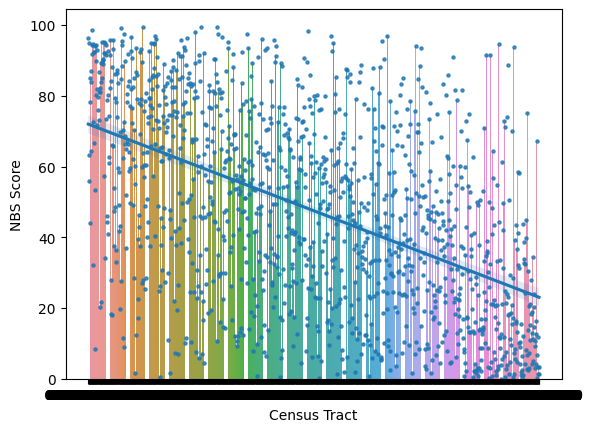

In [21]:
# plot regplot with numbers 0,..,len(a) as x value
fig, ax = plt.subplots()

sns.barplot(data=all_merged, x='Census Tract', y='NBS Score', order = all_merged['Census Tract'])

sns.regplot(x=np.arange(0,len(all_merged)), y=all_merged['NBS Score'], ax=ax, scatter_kws={"s": 5})
plt.show()

In [22]:
all_merged['differences'] = all_merged[' CES 4.0 Percentile'] - all_merged['NBS Score']
all_merged = all_merged.sort_values('differences', ascending=False)
all_merged

,Census Tract,Total Population,California County,ZIP,Nearby City \n(to help approximate location only),Longitude,Latitude,DRAFT CES 4.0 Score,DRAFT CES 4.0 Percentile,DRAFT CES 4.0\nPercentile Range,...,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl,CES 4.0 Percentile,CES Score,census_tract,Total,NBS Score,differences
19,6095250801,4073,Solano,94592,Vallejo,-122.330243,38.129394,51.201180,89.987390,85-90%,...,64.204402,71.513539,7.414648,81.778058,89.987390,98.730795,6095250801,53044,8.446712,81.540678
139,6095252702,6729,Solano,94585,Suisun City,-121.983989,38.143592,35.369950,69.798235,65-70%,...,53.756641,52.439715,5.437040,53.984868,69.798235,89.311957,6095252702,147995,1.587302,68.210933
33,6013358000,6195,Contra Costa,94572,Rodeo,-122.253849,38.048186,47.362804,86.191677,85-90%,...,42.044017,66.297113,6.873799,74.754098,86.191677,97.595190,6013358000,21210,20.351474,65.840203
105,6013378000,3284,Contra Costa,94801,Richmond,-122.404809,37.944825,37.766931,73.404792,70-75%,...,38.173539,49.590221,5.141600,49.697352,73.404792,91.850367,6013378000,49761,8.843537,64.561255
37,6095252402,5518,Solano,94534,Fairfield,-122.069369,38.220407,47.046500,85.674653,85-90%,...,67.518341,74.674125,7.742343,85.750315,85.674653,97.327989,6095252402,19742,21.768707,63.905946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,6075020300,3413,San Francisco,94114,San Francisco,-122.429437,37.764941,4.211819,2.131148,1-5% (lowest scores),...,28.434101,12.968968,1.344645,2.484237,2.131148,6.546426,6075020300,1601,88.690476,-86.559329
1174,6075015802,3321,San Francisco,94115,San Francisco,-122.438502,37.778079,5.461239,4.199243,1-5% (lowest scores),...,8.588414,13.901646,1.441347,3.076923,4.199243,11.022044,6075015802,1237,91.581633,-87.382389
1186,6075012902,4026,San Francisco,94123,San Francisco,-122.432103,37.800615,5.198459,3.631778,1-5% (lowest scores),...,39.754617,8.874124,0.920085,0.668348,3.631778,10.086840,6075012902,1221,91.666667,-88.034889
1210,6075012601,2630,San Francisco,94123,San Francisco,-122.439148,37.802270,4.709675,2.938209,1-5% (lowest scores),...,33.240577,8.150735,0.845082,0.517024,2.938209,8.483634,6075012601,744,94.756236,-91.818026


In [23]:
twentyfive = round(len(all_merged) * 0.25)
twentyfive

332

In [24]:
top_negative = all_merged[['Census Tract', 'California County', 'Nearby City \n(to help approximate location only)', 'differences']].sort_values("differences", ascending = True)
np.round(top_negative['differences'], 2).iloc[:10].to_list()

[-92.29,
 -91.82,
 -88.03,
 -87.38,
 -86.56,
 -82.52,
 -80.83,
 -80.76,
 -79.97,
 -77.94]

In [25]:
np.round(top_negative["differences"], 2).iloc[:10]

1254   -92.29
1210   -91.82
1186   -88.03
1174   -87.38
1237   -86.56
1076   -82.52
982    -80.83
965    -80.76
882    -79.97
867    -77.94
Name: differences, dtype: float64

In [26]:
grouped_by_county = all_merged[['California County', 'differences']].groupby('California County').mean()
grouped_by_county

,differences
California County,
Alameda,-18.746074
Contra Costa,0.877454
Marin,1.585746
Napa,11.131275
San Francisco,-46.450422
San Mateo,-12.912386
Santa Clara,-17.871413
Solano,7.674823
Sonoma,3.067972


In [27]:
for num in np.round(grouped_by_county["differences"], 2).to_list():
    print(num)

-18.75
0.88
1.59
11.13
-46.45
-12.91
-17.87
7.67
3.07


In [28]:
top_positive = all_merged[['Census Tract', 'California County', 'Nearby City \n(to help approximate location only)', 'differences']].sort_values("differences", ascending = False)
top_positive

,Census Tract,California County,Nearby City \n(to help approximate location only),differences
19,6095250801,Solano,Vallejo,81.540678
139,6095252702,Solano,Suisun City,68.210933
33,6013358000,Contra Costa,Rodeo,65.840203
105,6013378000,Contra Costa,Richmond,64.561255
37,6095252402,Solano,Fairfield,63.905946
...,...,...,...,...
1237,6075020300,San Francisco,San Francisco,-86.559329
1174,6075015802,San Francisco,San Francisco,-87.382389
1186,6075012902,San Francisco,San Francisco,-88.034889
1210,6075012601,San Francisco,San Francisco,-91.818026


In [29]:
all_merged["abs difference"] = np.abs(all_merged["differences"])
near_zero = all_merged.groupby('California County').mean()
near_zero = near_zero.sort_values("abs difference", ascending = True)[['abs difference', " CES 4.0 Percentile", "NBS Score"]].iloc[0:10, :]
near_zero = near_zero.sort_values("NBS Score")
near_zero

,abs difference,CES 4.0 Percentile,NBS Score
California County,,,
Marin,11.881423,12.874011,11.288265
Sonoma,14.911933,27.224324,24.156352
Napa,15.801526,36.218080,25.086806
Contra Costa,17.344775,36.468570,35.591115
Solano,21.370550,45.388262,37.713439
San Mateo,21.126519,25.977119,38.889505
Santa Clara,22.983058,28.516467,46.387880
Alameda,23.300087,41.632902,60.378976
San Francisco,47.596986,29.530072,75.980494


In [30]:
near_zero["NBS Score"].to_list()

[11.288265306122444,
 24.15635235575711,
 25.08680555555555,
 35.591115233972374,
 37.71343878917027,
 38.88950507739329,
 46.387880305496424,
 60.37897615186426,
 75.98049423851171]

In [31]:
all_merged["abs difference"] = np.abs(all_merged["differences"])
near_zero = all_merged.sort_values("abs difference", ascending = True)[['Census Tract', 'California County', 'Nearby City \n(to help approximate location only)', 'differences', " CES 4.0 Percentile", "NBS Score"]].iloc[0:10, :]
near_zero.sort_values("NBS Score")

,Census Tract,California County,Nearby City \n(to help approximate location only),differences,CES 4.0 Percentile,NBS Score
1282,6081611400,San Mateo,Atherton,-0.099853,0.920555,1.020408
1275,6081605700,San Mateo,Burlingame,-0.036687,1.097100,1.133787
757,6013359203,Contra Costa,Hercules,0.073775,23.203026,23.129252
661,6055200504,Napa,Napa,-0.172370,28.965952,29.138322
556,6097150609,Sonoma,Petaluma,0.148264,34.615385,34.467120
548,6055200707,Napa,Napa,0.070279,35.359395,35.289116
443,6095250105,Solano,Vallejo,-0.045494,42.358134,42.403628
136,6095251100,Solano,Vallejo,-0.042463,70.365700,70.408163
59,6013368002,Contra Costa,San Pablo,0.156528,80.315259,80.158730
31,6001409200,Alameda,Oakland,0.030697,86.708701,86.678005


/tmp/ipykernel_76/3893628168.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(data = all_merged, x = "NBS Score", shade = True, color = 'r', label = "NBS Score")
/tmp/ipykernel_76/3893628168.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(data = all_merged, x = " CES 4.0 Percentile", shade=True, color="b", label = "CalEnviroScreen 4.0")


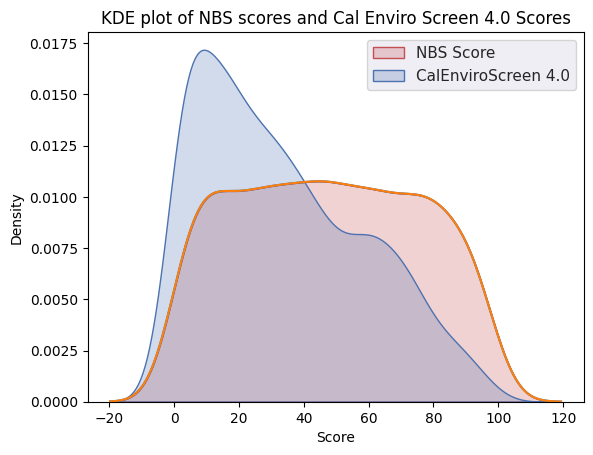

In [32]:
sns.kdeplot(data = all_merged, x = "NBS Score")
sns.kdeplot(data = all_merged, x = "NBS Score")

plt.title("KDE plot of NBS scores and Cal Enviro Screen 4.0 Scores")

sns.set(style="darkgrid")
 
# plotting both distibutions on the same figure
fig = sns.kdeplot(data = all_merged, x = "NBS Score", shade = True, color = 'r', label = "NBS Score")
fig = sns.kdeplot(data = all_merged, x = " CES 4.0 Percentile", shade=True, color="b", label = "CalEnviroScreen 4.0")
plt.legend()
plt.xlabel("Score")
plt.show()

From this plot, we see that in general there are higher NBS scores than Cal EnviroScreen 4.0 scores. The score o

In [33]:
print("the minimum NBS score: ", all_merged["NBS Score"].min())
print("the minimum CalEnviroScreen 4.0 score", all_merged[" CES 4.0 Percentile"].min())
print("the max NBS score: ", all_merged["NBS Score"].max())
print("the max CalEnviroScreen 4.0 score", all_merged[" CES 4.0 Percentile"].max())

the minimum NBS score:  0.05668934240362944
the minimum CalEnviroScreen 4.0 score 0.0126103404791929
the max NBS score:  99.54648526077098
the max CalEnviroScreen 4.0 score 97.9571248423707


In [34]:
#sns.kdeplot(data = all_merged, x = " CES 4.0 Percentile", y = "NBS Score")
#plt.title("Density Plot between CalEnviroScreen 4.0 and NBS Scores")
#print("From this plot, we can see that there's a roughly linear distribution between the two but that there's a lot of variation when going to higher scores (showing that there are kinda similar)")

In [35]:
all_merged['highest_combined'] = all_merged[' CES 4.0 Percentile'] + all_merged['NBS Score']
highest_combined = all_merged.sort_values('highest_combined', ascending=False)
highest_combined

,Census Tract,Total Population,California County,ZIP,Nearby City \n(to help approximate location only),Longitude,Latitude,DRAFT CES 4.0 Score,DRAFT CES 4.0 Percentile,DRAFT CES 4.0\nPercentile Range,...,Pop. Char. Score,Pop. Char. Pctl,CES 4.0 Percentile,CES Score,census_tract,Total,NBS Score,differences,abs difference,highest_combined
0,6001407300,2440,Alameda,94601,Oakland,-122.210924,37.762179,64.580115,97.957125,95-100% (highest scores),...,8.708981,95.825977,97.957125,100.000000,6001407300,418,96.371882,1.585243,1.585243,194.329007
1,6001408800,7054,Alameda,94621,Oakland,-122.196942,37.758804,63.194836,97.477932,95-100% (highest scores),...,9.412691,99.205549,97.477932,99.933200,6001408800,740,94.841270,2.636662,2.636662,192.319202
10,6001403000,2969,Alameda,94607,Oakland,-122.270732,37.800427,54.455906,92.749054,90-95%,...,8.493399,94.249685,92.749054,99.331997,6001403000,115,98.526077,-5.777023,5.777023,191.275131
12,6001406100,4659,Alameda,94601,Oakland,-122.227594,37.774155,54.081076,92.597730,90-95%,...,7.854803,87.263556,92.597730,99.198397,6001406100,789,94.501134,-1.903404,1.903404,187.098864
15,6001409500,4272,Alameda,94621,Oakland,-122.183766,37.750446,52.191381,90.983607,90-95%,...,9.379771,99.092055,90.983607,98.997996,6001409500,744,94.756236,-3.772629,3.772629,185.739842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,6081611400,4316,San Mateo,94027,Atherton,-122.214767,37.446300,3.227065,0.920555,1-5% (lowest scores),...,0.669500,0.226986,0.920555,3.273213,6081611400,161986,1.020408,-0.099853,0.099853,1.940963
1325,6041127000,4678,Marin,94941,Mill Valley,-122.558505,37.910441,1.550410,0.063052,1-5% (lowest scores),...,0.617762,0.151324,0.063052,0.334001,6041127000,150627,1.417234,-1.354182,1.354182,1.480285
1329,6041126100,6145,Marin,94941,Mill Valley,-122.540486,37.912151,1.253363,0.012610,1-5% (lowest scores),...,0.420744,0.025221,0.012610,0.066800,6041126100,154162,1.303855,-1.291245,1.291245,1.316465
1280,6041115000,7288,Marin,94960,San Anselmo,-122.583156,38.005696,3.292099,0.970996,1-5% (lowest scores),...,1.036020,1.122320,0.970996,3.406814,6041115000,208444,0.283447,0.687550,0.687550,1.254443


In [36]:
highest_combined = highest_combined[['Census Tract', 'California County', 'Nearby City \n(to help approximate location only)', 'highest_combined']]
highest_combined

,Census Tract,California County,Nearby City \n(to help approximate location only),highest_combined
0,6001407300,Alameda,Oakland,194.329007
1,6001408800,Alameda,Oakland,192.319202
10,6001403000,Alameda,Oakland,191.275131
12,6001406100,Alameda,Oakland,187.098864
15,6001409500,Alameda,Oakland,185.739842
...,...,...,...,...
1282,6081611400,San Mateo,Atherton,1.940963
1325,6041127000,Marin,Mill Valley,1.480285
1329,6041126100,Marin,Mill Valley,1.316465
1280,6041115000,Marin,San Anselmo,1.254443


In [37]:
#finding the percentiles 
top_25 = highest_combined.iloc[0:twentyfive, :]
top_25["City"] = top_25["Nearby City \n(to help approximate location only)"]
top_25


/tmp/ipykernel_76/818909075.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_25["City"] = top_25["Nearby City \n(to help approximate location only)"]


,Census Tract,California County,Nearby City \n(to help approximate location only),highest_combined,City
0,6001407300,Alameda,Oakland,194.329007,Oakland
1,6001408800,Alameda,Oakland,192.319202,Oakland
10,6001403000,Alameda,Oakland,191.275131,Oakland
12,6001406100,Alameda,Oakland,187.098864,Oakland
15,6001409500,Alameda,Oakland,185.739842,Oakland
...,...,...,...,...,...
867,6001403701,Alameda,Oakland,113.220098,Oakland
503,6085504806,Santa Clara,Sunnyvale,112.919408,Sunnyvale
630,6081600402,San Mateo,Daly City,112.779279,Daly City
541,6075047701,San Francisco,San Francisco,112.696497,San Francisco


In [38]:
top_25["City"].value_counts()

Oakland                60
San Francisco          59
San Jose               49
Hayward                26
San Leandro            15
Richmond               13
Emeryville             10
Pittsburg              10
Vallejo                 9
Redwood City            8
Berkeley                8
Antioch                 6
San Pablo               6
Daly City               4
Alameda                 4
San Mateo               4
El Cerrito              4
Sunnyvale               4
Concord                 4
San Lorenzo             4
Union City              3
Fairfield               2
Fremont                 2
Newark                  2
South San Francisco     2
Gilroy                  2
Castro Valley           2
Milpitas                2
Santa Clara             1
Palo Alto               1
San Bruno               1
Morgan Hill             1
Napa                    1
Albany                  1
Oakley                  1
Santa Rosa              1
Name: City, dtype: int64

All near the same area in Oakland. A lot of them are designated opportunity zones (allowing for certain investments in lower income areas to have tax advantages) 

In [39]:
print("Highest NBS Score")
highest_NBS_scores = all_merged.sort_values("NBS Score", ascending = False)[["Census Tract", "California County", "Nearby City \n(to help approximate location only)", "NBS Score"]].iloc[:10, :]
highest_NBS_scores

Highest NBS Score


,Census Tract,California County,Nearby City \n(to help approximate location only),NBS Score
332,6075012302,San Francisco,San Francisco,99.546485
160,6075012301,San Francisco,San Francisco,99.489796
380,6075012202,San Francisco,San Francisco,99.433107
97,6075012502,San Francisco,San Francisco,99.206349
10,6001403000,Alameda,Oakland,98.526077
647,6075011901,San Francisco,San Francisco,98.356009
316,6075011300,San Francisco,San Francisco,98.072562
469,6075012100,San Francisco,San Francisco,97.562358
383,6075011700,San Francisco,San Francisco,97.448980
106,6001403100,Alameda,Oakland,97.392290


In [40]:
print("Highest CES Score")
highest_CES_scores = all_merged.sort_values(" CES 4.0 Percentile", ascending = False)[["Census Tract", "California County", "Nearby City \n(to help approximate location only)", " CES 4.0 Percentile"]]
highest_CES_scores.index

Highest CES Score


Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329],
           dtype='int64', length=1330)

Top 25% of highest scores of CES. 

In [41]:
highest_CES_scores.iloc[:twentyfive, :]["Nearby City \n(to help approximate location only)"].value_counts().loc[lambda x: x > 5]

Oakland          56
San Jose         45
San Francisco    27
Hayward          26
Vallejo          17
San Leandro      14
Richmond         14
San Pablo         9
Emeryville        9
Pittsburg         9
Antioch           8
Fairfield         8
Redwood City      8
Napa              7
Concord           7
Berkeley          6
Name: Nearby City \n(to help approximate location only), dtype: int64

In [42]:
#no overlap between the highest NBS scores and CES scores 
highest_CES_scores.merge(highest_NBS_scores, left_on = "Census Tract", right_on = "Census Tract")

,Census Tract,California County_x,Nearby City \n(to help approximate location only)_x,CES 4.0 Percentile,California County_y,Nearby City \n(to help approximate location only)_y,NBS Score
0,6001403000,Alameda,Oakland,92.749054,Alameda,Oakland,98.526077
1,6075012502,San Francisco,San Francisco,74.211854,San Francisco,San Francisco,99.206349
2,6001403100,Alameda,Oakland,73.291299,Alameda,Oakland,97.392290
3,6075012301,San Francisco,San Francisco,67.578815,San Francisco,San Francisco,99.489796
4,6075011300,San Francisco,San Francisco,53.165195,San Francisco,San Francisco,98.072562
5,6075012302,San Francisco,San Francisco,51.803279,San Francisco,San Francisco,99.546485
6,6075012202,San Francisco,San Francisco,46.809584,San Francisco,San Francisco,99.433107
7,6075011700,San Francisco,San Francisco,46.658260,San Francisco,San Francisco,97.448980
8,6075012100,San Francisco,San Francisco,40.466583,San Francisco,San Francisco,97.562358
9,6075011901,San Francisco,San Francisco,29.356873,San Francisco,San Francisco,98.356009


In [43]:
print("overlap between the highest CES scores and highest combined scores")
highest_CES_scores.merge(highest_combined, left_on = "Census Tract", right_on = "Census Tract")

overlap between the highest CES scores and highest combined scores


,Census Tract,California County_x,Nearby City \n(to help approximate location only)_x,CES 4.0 Percentile,California County_y,Nearby City \n(to help approximate location only)_y,highest_combined
0,6001407300,Alameda,Oakland,97.957125,Alameda,Oakland,194.329007
1,6001408800,Alameda,Oakland,97.477932,Alameda,Oakland,192.319202
2,6001409000,Alameda,Oakland,97.263556,Alameda,Oakland,160.415484
3,6095250701,Solano,Vallejo,96.872636,Solano,Vallejo,152.768327
4,6013365002,Contra Costa,Richmond,95.737705,Contra Costa,Richmond,139.728635
...,...,...,...,...,...,...,...
1325,6041127000,Marin,Mill Valley,0.063052,Marin,Mill Valley,1.480285
1326,6013352101,Contra Costa,Moraga,0.050441,Contra Costa,Moraga,11.785135
1327,6013353002,Contra Costa,Orinda,0.037831,Contra Costa,Orinda,3.212434
1328,6013351200,Contra Costa,Lafayette,0.025221,Contra Costa,Lafayette,3.426581


In [44]:
print("overlap between the highest NBS scores and highest combined scores")
highest_NBS_scores.merge(highest_combined, left_on = "Census Tract", right_on = "Census Tract")

overlap between the highest NBS scores and highest combined scores


,Census Tract,California County_x,Nearby City \n(to help approximate location only)_x,NBS Score,California County_y,Nearby City \n(to help approximate location only)_y,highest_combined
0,6075012302,San Francisco,San Francisco,99.546485,San Francisco,San Francisco,151.349764
1,6075012301,San Francisco,San Francisco,99.489796,San Francisco,San Francisco,167.068611
2,6075012202,San Francisco,San Francisco,99.433107,San Francisco,San Francisco,146.242690
3,6075012502,San Francisco,San Francisco,99.206349,San Francisco,San Francisco,173.418203
4,6001403000,Alameda,Oakland,98.526077,Alameda,Oakland,191.275131
5,6075011901,San Francisco,San Francisco,98.356009,San Francisco,San Francisco,127.712882
6,6075011300,San Francisco,San Francisco,98.072562,San Francisco,San Francisco,151.237758
7,6075012100,San Francisco,San Francisco,97.562358,San Francisco,San Francisco,138.028941
8,6075011700,San Francisco,San Francisco,97.448980,San Francisco,San Francisco,144.107239
9,6001403100,Alameda,Oakland,97.392290,Alameda,Oakland,170.683589


In [ ]:
oakland = our_scores[["census_tract", "wetlands_value", "vernalpools_value", "naturalriver_value", "naturalbaylands_value", "hirechargevulnerable_value", "floodplain500_natural_value", "carbon_urbanforest_value", "drinkingwater_value"]]
oakland = oakland[oakland['census_tract'] == 6001407300]
oakland

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=08c08e4f-c970-41e1-98db-afa3328b10c6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>